In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms

In [2]:
sns.set_theme()

In [3]:
# p-value utility function
def p_value(distribution, difference):
    """
    returns the two-sided p-value of seeing a difference of at least `difference`
    assumes `difference` is positive
    `distribution` is a list of samples from the difference distribution
    """
    pos_count = ((0 < distribution) & (distribution < difference)).sum()
    neg_count = ((distribution < 0) & ((-1*difference) < distribution)).sum()
    return 1 - (pos_count + neg_count)/len(distribution)    

In [4]:
SAMPLE_SIZE = 100
NUM_SAMPLES = 100000
A, B = (5, 15)

## Generating two samples from a uniform distribution 5 - 15

In [5]:
samples = pd.DataFrame({"metric": stats.uniform.rvs(loc=A, scale=(B-A), size=SAMPLE_SIZE*2),
                        "is_variant": np.concatenate([np.zeros(SAMPLE_SIZE, dtype=int), np.ones(SAMPLE_SIZE, dtype=int)])})

sample_means = samples.groupby("is_variant").agg(["count", "mean", "var"])
sample_diff = sample_means.loc[1]["metric"]["mean"] - sample_means.loc[0]["metric"]["mean"]

print("Sample Diff: {:f}".format(sample_diff))
sample_means

Sample Diff: 0.482912


metric                     
            count       mean       var
is_variant                            
0             100   9.796673  9.043704
1             100  10.279585  7.221348

## Ideal Distribution

In [6]:
ideal_samples = stats.uniform.rvs(loc=5, scale=10, size=(2, NUM_SAMPLES, SAMPLE_SIZE))

p-value 0.23607
ci [-0.31812281  1.28074348]


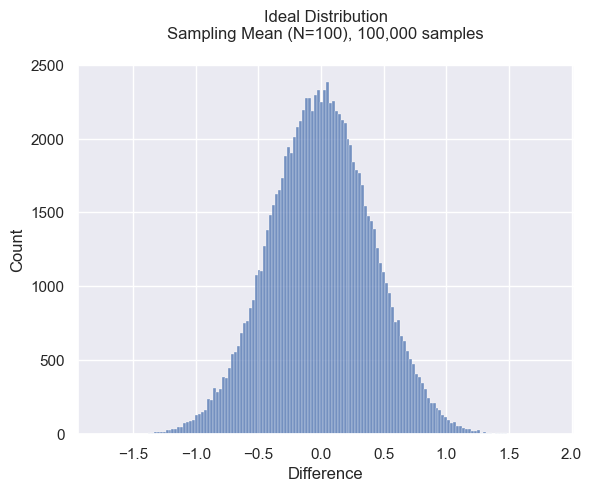

In [7]:
ideal_means = ideal_samples.mean(axis=2)
ideal_diffs = ideal_means[1] - ideal_means[0]

f, ax = plt.subplots(1, 1)
sns.histplot(ideal_diffs, ax=ax)
ax.set_title("Ideal Distribution\n"
             "Sampling Mean (N={:,d}), {:,d} samples\n".format(SAMPLE_SIZE, NUM_SAMPLES))
ax.set_xlabel("Difference");

print("p-value", p_value(ideal_diffs, abs(sample_diff)))
print("ci", np.percentile(ideal_diffs, [2.5, 97.5])+sample_diff)

## Bootstrapped Distribution

In [8]:
permutation_choices = stats.binom.rvs(n=1, p=0.5, size=(SAMPLE_SIZE*2, NUM_SAMPLES))
print(permutation_choices.shape)
permutation_choices

(200, 100000)


array([[1, 1, 0, ..., 1, 0, 1],
       [1, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 1]])

p-value 0.23228000000000004
ci [-0.30347306  1.2726317 ]


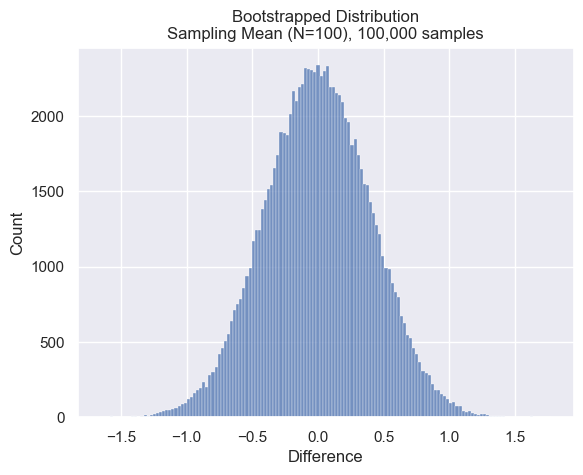

In [9]:
base_means = np.matmul(samples["metric"].values.reshape(1, -1), permutation_choices)/permutation_choices.sum(axis=0)
vari_means = np.matmul(samples["metric"].values.reshape(1, -1), (1-permutation_choices))/(1-permutation_choices).sum(axis=0)
bootstrapped_diffs = (vari_means - base_means).ravel()

f, ax = plt.subplots(1, 1)
sns.histplot(bootstrapped_diffs, ax=ax)
ax.set_title("Bootstrapped Distribution\n"
             "Sampling Mean (N={:,d}), {:,d} samples".format(SAMPLE_SIZE, NUM_SAMPLES))
ax.set_xlabel("Difference")

print("p-value", p_value(bootstrapped_diffs, abs(sample_diff)))
print("ci", np.percentile(bootstrapped_diffs, [2.5, 97.5])+sample_diff)

## Two-Sample T Test

p-value 0.23258097384314902
ci [-0.31240157  1.27822589]


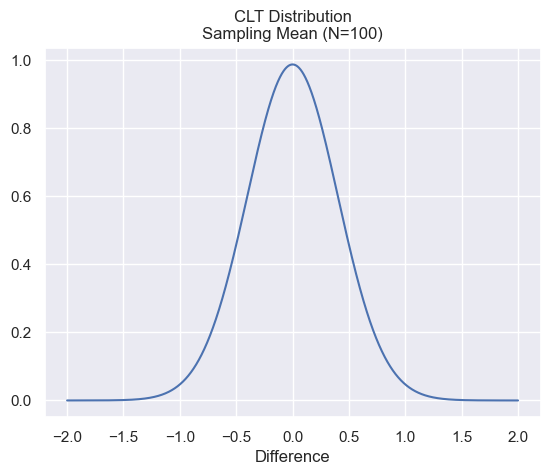

In [10]:
df = sample_means["metric", "count"].sum() - 2
var = (sample_means["metric", "var"]/sample_means["metric", "count"]).sum()
t_dist = stats.t(df, 0, scale=np.sqrt(var))

xs = np.linspace(-2, 2, 10000)
ys = t_dist.pdf(xs)
f, ax = plt.subplots(1, 1)
ax.plot(xs, ys)
ax.set_title("CLT Distribution\n"
             "Sampling Mean (N={:,d})".format(SAMPLE_SIZE))
ax.set_xlabel("Difference")

print("p-value", (1-t_dist.cdf(abs(sample_diff))) + t_dist.cdf(-abs(sample_diff)))
print ("ci",
        stats.t(sample_means["metric", "count"].sum() - 2,
                loc=sample_diff,
                scale=np.sqrt(var)).ppf([0.025, 0.975]))

## OLS

In [11]:
X = samples["is_variant"]
X = sm.add_constant(X)
y = samples["metric"]

In [12]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 metric   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.434
Date:                Wed, 30 Nov 2022   Prob (F-statistic):              0.233
Time:                        15:07:18   Log-Likelihood:                -492.37
No. Observations:                 200   AIC:                             988.7
Df Residuals:                     198   BIC:                             995.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7967      0.285     34.353      0.0

## P-Value Comparison

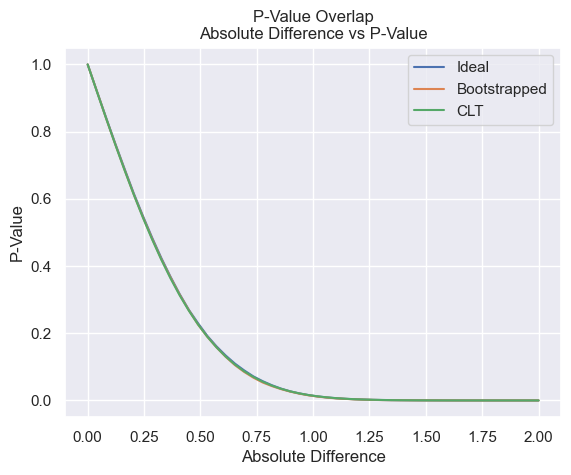

In [13]:
xs = np.linspace(0, 2, 50)
ideal_ys = [p_value(ideal_diffs, x) for x in xs]
bootstrapped_ys = [p_value(bootstrapped_diffs, x) for x in xs]
clt_ys = (1-t_dist.cdf(xs)) + t_dist.cdf(-xs)

f, ax = plt.subplots(1, 1)
ax.plot(xs, ideal_ys, label="Ideal")
ax.plot(xs, bootstrapped_ys, label="Bootstrapped")
ax.plot(xs, clt_ys, label="CLT")
ax.set_title("P-Value Overlap\n"
             "Absolute Difference vs P-Value")
ax.set_xlabel("Absolute Difference")
ax.set_ylabel("P-Value")
ax.legend()

In [14]:
pd.DataFrame({"method": ["ideal", "bootstrapped", "clt", "ttest_ind", "OLS"],
              "p-value": [p_value(ideal_diffs, abs(sample_diff)),
                          p_value(bootstrapped_diffs, abs(sample_diff)),
                          (1-t_dist.cdf(abs(sample_diff))) + t_dist.cdf(-abs(sample_diff)),
                          stats.ttest_ind(samples.loc[samples["is_variant"] == 0]["metric"], 
                                          samples.loc[samples["is_variant"] == 1]["metric"], 
                                          equal_var=False)[1],
                          results.pvalues["is_variant"]]})

,method,p-value
0,ideal,0.236070
1,bootstrapped,0.232280
2,clt,0.232581
3,ttest_ind,0.232599
4,OLS,0.232581


## Confidence Interval Comparison

In [15]:
(pd.DataFrame({"method": ["ideal", "bootstrapped", "clt", "OLS"],
               "conf_int": [np.percentile(ideal_diffs, [2.5, 97.5])+sample_diff,
                            np.percentile(bootstrapped_diffs, [2.5, 97.5])+sample_diff,
                            stats.t(sample_means["metric", "count"].sum() - 2,
                                    loc=sample_diff,
                                    scale=np.sqrt(var)).ppf([0.025, 0.975]),
                            (results.conf_int()[0][1], results.conf_int()[1][1])]})
 .assign(conf_lower=lambda df: df["conf_int"].apply(lambda t: t[0]),
         conf_upper=lambda df: df["conf_int"].apply(lambda t: t[1]))
 .drop(columns="conf_int"))

,method,conf_lower,conf_upper
0,ideal,-0.318123,1.280743
1,bootstrapped,-0.303473,1.272632
2,clt,-0.312402,1.278226
3,OLS,-0.312402,1.278226
